# Get The Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Read the csv file and analyze the column names

In [3]:
data= pd.read_csv(r"C:\Work\Datasets\Turbine_Data.csv")
x=list(data['ActivePower'])
y=list(data['WindSpeed'])
data.columns

Index(['Unnamed: 0', 'ActivePower', 'AmbientTemperatue',
       'BearingShaftTemperature', 'Blade1PitchAngle', 'Blade2PitchAngle',
       'Blade3PitchAngle', 'ControlBoxTemperature',
       'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorRPM',
       'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature',
       'HubTemperature', 'MainBoxTemperature', 'NacellePosition',
       'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG', 'WindDirection',
       'WindSpeed'],
      dtype='object')

# Plot the heatmap and check the correlation

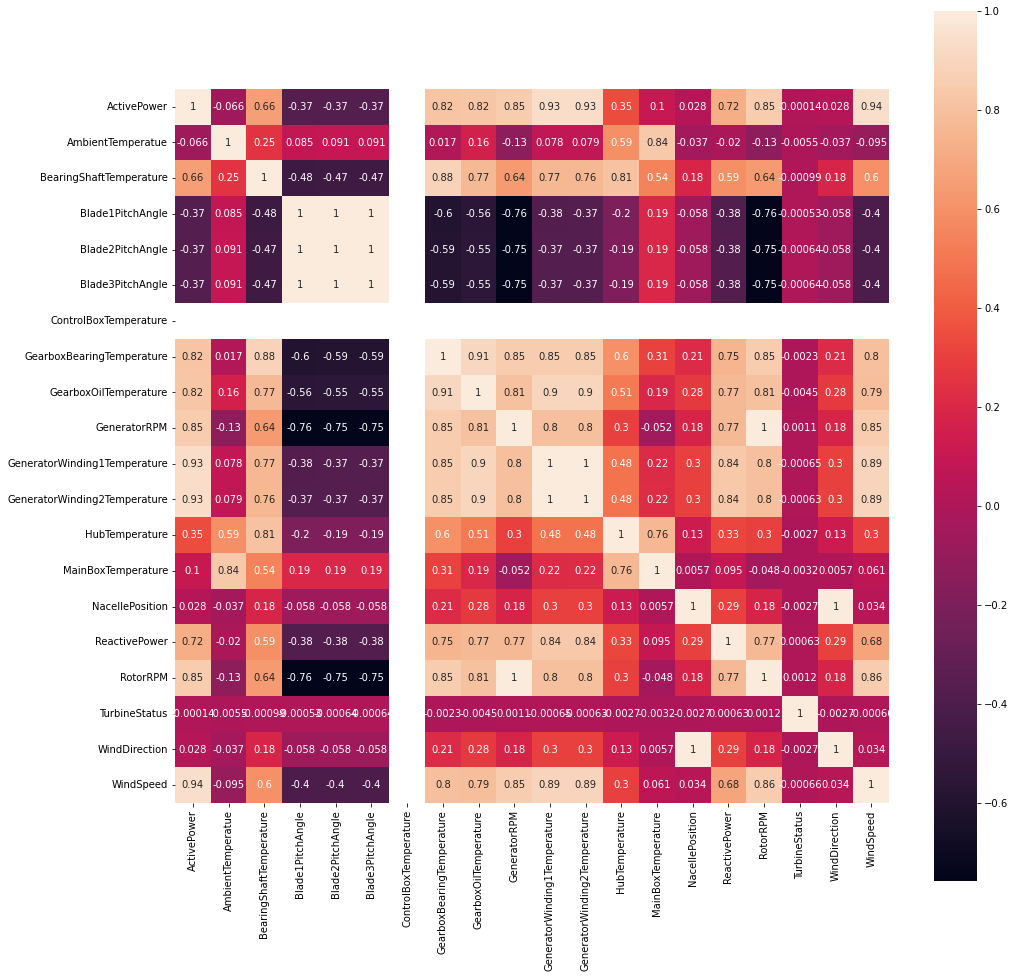

In [4]:
plt.subplots(figsize=(16, 16))
sns.heatmap(data.corr(), annot=True, square=True)
plt.show()

# Generate the timestamp according to the datasset

# In order to reduce redundancy we only used the most highly correlated featuer i.e. the WindPower

In [5]:
timestamp=pd.date_range('2017-12-31', periods=118224, freq='10T')
timestamp_df= pd.Series(timestamp)
inputs_df= pd.DataFrame(x, timestamp, columns=['ActivePower'])
inputs_df['Windspeed']=y
inputs_df= inputs_df.fillna(0).astype(float)
inputs_df.head()

,ActivePower,Windspeed
2017-12-31 00:00:00,0.0,0.0
2017-12-31 00:10:00,0.0,0.0
2017-12-31 00:20:00,0.0,0.0
2017-12-31 00:30:00,0.0,0.0
2017-12-31 00:40:00,0.0,0.0


# Pick only the second half of the dataset, to get the proper data with less NaNs

In [47]:
inputs_df = inputs_df.loc['2019-06-01':]
inputs_df.head()

,ActivePower,Windspeed
2019-06-01 00:00:00,1713.485915,9.202714
2019-06-01 00:10:00,1714.883830,9.966564
2019-06-01 00:20:00,1720.180320,9.778244
2019-06-01 00:30:00,1721.746230,9.805549
2019-06-01 00:40:00,1723.882119,10.093831


# Plot active power variation in the data

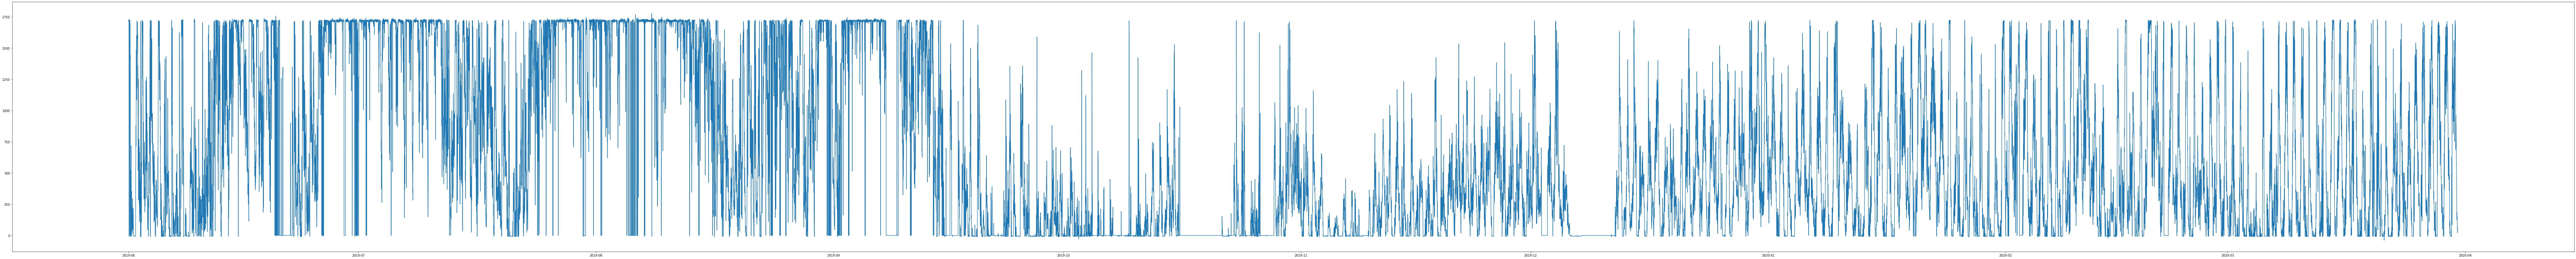

In [9]:
plt.figure(figsize=(150,15))
plt.plot(inputs_df['ActivePower'])

# Split data into test and train with 80% of the data being used for training

In [10]:
l=len(inputs_df['ActivePower'])
x_train= inputs_df['ActivePower'][:int(0.8*l)]
x_test= inputs_df['ActivePower'][int(0.8*l):]
x_test

2020-01-30 04:40:00    -6.163405
2020-01-30 04:50:00    -5.824133
2020-01-30 05:00:00    -5.848914
2020-01-30 05:10:00    -5.852757
2020-01-30 05:20:00    -5.370329
                         ...    
2020-03-30 23:10:00    70.044465
2020-03-30 23:20:00    40.833474
2020-03-30 23:30:00    20.777790
2020-03-30 23:40:00    62.091039
2020-03-30 23:50:00    68.664425
Freq: 10T, Name: ActivePower, Length: 8756, dtype: float64

# Importing ARIMA(auto regressive model with moving average) to predict values

In [11]:
model = sm.tsa.arima.ARIMA(x_train, order=(1,1,2))
result = model.fit().predict(l-int(0.8*l))
result.shape

(26264,)

In [12]:
start=str(result.index[0])
end= str(result.index[len(result.index)-1])
x_true=inputs_df['ActivePower'][start:end]

# Plot prediction of ARIMA and the True Value

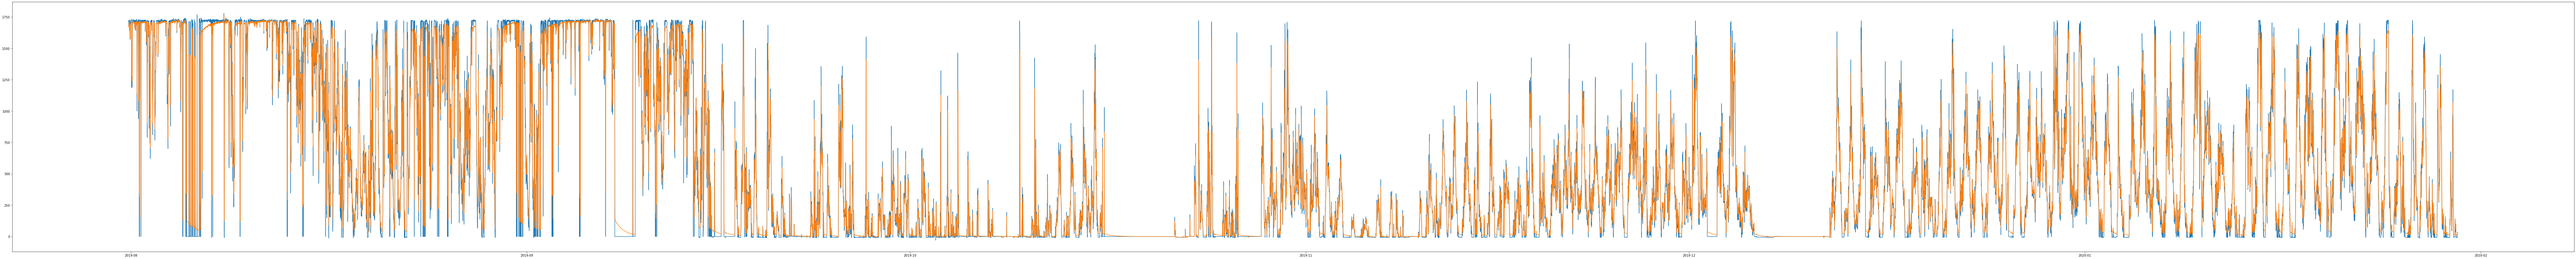

In [13]:
plt.figure(figsize=(150,15))
plt.plot(x_true)
plt.plot(result)


# Correlation between Predicted and True Value

In [14]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(x_true, result)
correlation

0.9643062459494881

# Creating a function to generate Dataset for LSTM predictor

In [15]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    n_features = ts.shape[1]
    

    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

# Defining some standard training variables

In [16]:
lag = 360
n_ahead = 144
train_share = 0.8
epochs = 20
batch_size = 512
lr = 0.001
ts= inputs_df

# Scale the data to ease out the training process

In [17]:
scaler = MinMaxScaler()
scaler.fit(ts)
ts_scaled = scaler.transform(ts)

# Splitting the data for training and predicting purpose

In [18]:
X, Y = create_X_Y(ts_scaled, lag=lag, n_ahead=n_ahead)
Xtrain, Ytrain = X[0:int(X.shape[0] * train_share)], Y[0:int(X.shape[0] * train_share)]
Xtest, Ytest = X[int(X.shape[0] * train_share):], Y[int(X.shape[0] * train_share):]

# Set up the base training model 

In [40]:
def get_model():
    model= Sequential([
        LSTM(32, return_sequences=False),
        Dense(144)
    ])
    return model

# Fitting and compiling the model with Adam optimizer and mae as loss function

In [41]:
model= get_model()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr), loss='mae', metrics=['mae'])
model.fit(Xtrain, Ytrain, shuffle=False, epochs=30, batch_size=batch_size)

Epoch 1/30
68/68 [==============================] - 4s 25ms/step - loss: 0.3347 - mae: 0.3347
Epoch 2/30
68/68 [==============================] - 2s 27ms/step - loss: 0.2494 - mae: 0.2494
Epoch 3/30
68/68 [==============================] - 2s 30ms/step - loss: 0.2372 - mae: 0.2372: 1s - lo
Epoch 4/30
68/68 [==============================] - 2s 32ms/step - loss: 0.2069 - mae: 0.2069
Epoch 5/30
68/68 [==============================] - 2s 32ms/step - loss: 0.2136 - mae: 0.2136
Epoch 6/30
68/68 [==============================] - 2s 33ms/step - loss: 0.2026 - mae: 0.2026
Epoch 7/30
68/68 [==============================] - 2s 32ms/step - loss: 0.2089 - mae: 0.2089: 0s - loss: 0.2067 - mae: 0
Epoch 8/30
68/68 [==============================] - 2s 32ms/step - loss: 0.2008 - mae: 0.2008
Epoch 9/30
68/68 [==============================] - 2s 32ms/step - loss: 0.2051 - mae: 0.2051
Epoch 10/30
68/68 [==============================] - 2s 31ms/step - loss: 0.1993 - mae: 0.1993
Epoch 11/30
68/68 [===

# Get predicitions from the model

In [42]:
pred= model.predict(Xtest)

# Inverse transform the predicted answer in order to analyze it

In [43]:
pred_n_ahead = pd.DataFrame(pred[0])
actual_n_ahead = pd.DataFrame(Ytest[0])

#repeat the column series 2 times, to make shape compatible for scale inversion
pr_p = pd.concat([pred_n_ahead]*2, axis=1)
ac_p = pd.concat([actual_n_ahead]*2, axis=1)

In [44]:
days = timestamp[-len(pred):-len(pred) + n_ahead]
days_df = pd.DataFrame(days)

# Genrating new dataframe with inverse the transformed predictions

In [45]:
pr_p = pd.DataFrame(scaler.inverse_transform(pr_p))
ac_p = pd.DataFrame(scaler.inverse_transform(ac_p))

#rename columns
pr_p = pr_p.rename(columns={0:'PredPower'})
ac_p = ac_p.rename(columns={0:'ActualPower'})

#concatenate together into one dataframe and set index
df_final = pd.concat([days_df, pr_p['PredPower'], ac_p['ActualPower']], axis=1).set_index(0)

# Plot the predicted and True values

<function matplotlib.pyplot.show(close=None, block=None)>

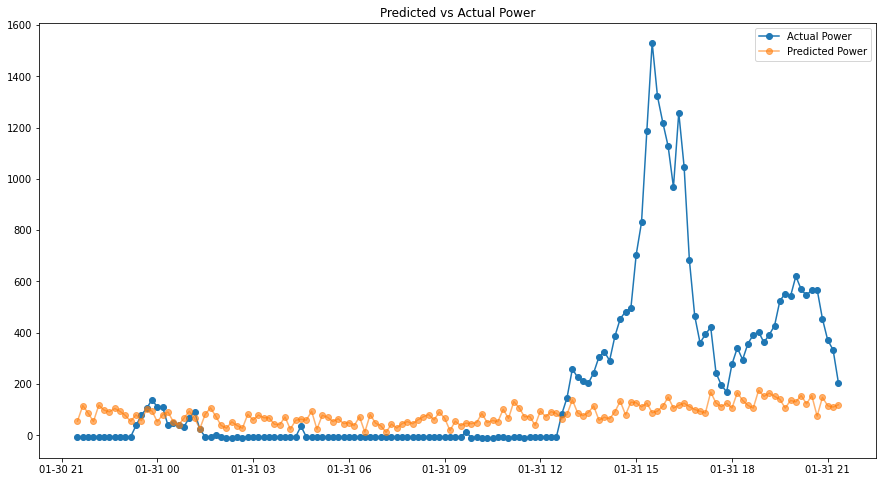

In [46]:
plt.figure(figsize=(15, 8))
plt.plot(df_final.index, df_final.ActualPower, color='C0', marker='o', label='Actual Power')
plt.plot(df_final.index, df_final.PredPower, color='C1', marker='o', label='Predicted Power', alpha=0.6)
plt.title('Predicted vs Actual Power')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.savefig('forecast_example.png')
plt.show

# Conclusion:
## Prediction with auto regressive model worked well rather than using LSTM RNNs to predict the power being genrated based on the feature Wind Power